# Linear Regression Project Tutorial

In [5]:
# Loading libraries:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# modelado
from sklearn.linear_model import LogisticRegression

# metricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# optimizar

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from IPython import get_ipython
from IPython.display import display


In [6]:
# STEP 1) Connect to the database and convert it to a dataframe
resource_url = "https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv"
df = pd.read_csv(resource_url, delimiter=',')


# Set a random seed to ensure reproducibility across runs
RNG_SEED = 42
np.random.seed(seed=RNG_SEED)


# STEP 2) Problem statement:
print("Problem statement: Calcuating the premium personalized (cost) of a health insurance for each customer of an insurance company, \n"
"based on the physiological data taken from other companies and a particular study, it has managed to gather a set of data to train a predictive model.")

display(df.head())

Problem statement: Calcuating the premium personalized (cost) of a health insurance for each customer of an insurance company, 
based on the physiological data taken from other companies and a particular study, it has managed to gather a set of data to train a predictive model.


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
# STEP 3) First data overiew: data status
df.info()

print(f"\n There are {df.isnull().any().sum()} columns with missing values in the database {', '.join(df.columns[df.isnull().any()])}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

 There are 0 columns with missing values in the database 


In [8]:
# STEP 4) Checking potential 'hidden' missing or nul values:

# 4.A) Find columns with non-varying values
non_varying_cols = [col for col in df.columns if df[col].nunique() == 1]
'''
1. `non_varying_cols = [col for col in df.columns if df[col].nunique() == 1]`:
  This line uses a list comprehension to iterate through each column (`col`) in the DataFrame (`df.columns`).
2. `df[col].nunique() == 1`: For each column, it checks if the number of unique values (`nunique()`) is equal to 1.
  If this condition is true, it means the column has only one unique value and is considered non-varying.
3. `[col for ... if ...]`: The list comprehension creates a list (`non_varying_cols`)
  containing the names of all columns that satisfy the condition (having only one unique value).
'''

df = df.drop(columns=non_varying_cols)

for col in df.columns:
    unique_values = df[col].unique()
    print(f"Column'{col}' unique values: {', '.join(map(str, unique_values))}")

print(f"\nAlthough in a first overview it seemed some variables had only one type of value,\n"
      f"based on this more in-depth check we find {len(non_varying_cols)} columns with non-distinc values.\n"
"After analysing all the columns and respective values, we decide to just rename the columns 'default', 'contact', 'duration', 'campaign', 'pdays', 'previous' by a more descriptive label 'credit', 'contact_type', 'contact_duration', 'num_contacts', 'elapsed_days', 'previous_contacts'")

df.rename(columns={'default': 'has_debth', 'housing': 'housing_loans', 'loan': 'personal_loan', 'contact': 'contact_type', 'duration': 'contact_duration', 'campaign':'num_contacts','pdays':'elapsed_days', 'previous':'previous_contacts'}, inplace=True)



Column'age' unique values: 19, 18, 28, 33, 32, 31, 46, 37, 60, 25, 62, 23, 56, 27, 52, 30, 34, 59, 63, 55, 22, 26, 35, 24, 41, 38, 36, 21, 48, 40, 58, 53, 43, 64, 20, 61, 44, 57, 29, 45, 54, 49, 47, 51, 42, 50, 39
Column'sex' unique values: female, male
Column'bmi' unique values: 27.9, 33.77, 33.0, 22.705, 28.88, 25.74, 33.44, 27.74, 29.83, 25.84, 26.22, 26.29, 34.4, 39.82, 42.13, 24.6, 30.78, 23.845, 40.3, 35.3, 36.005, 32.4, 34.1, 31.92, 28.025, 27.72, 23.085, 32.775, 17.385, 36.3, 35.6, 26.315, 28.6, 28.31, 36.4, 20.425, 32.965, 20.8, 36.67, 39.9, 26.6, 36.63, 21.78, 30.8, 37.05, 37.3, 38.665, 34.77, 24.53, 35.2, 35.625, 33.63, 28.0, 34.43, 28.69, 36.955, 31.825, 31.68, 22.88, 37.335, 27.36, 33.66, 24.7, 25.935, 22.42, 28.9, 39.1, 36.19, 23.98, 24.75, 28.5, 28.1, 32.01, 27.4, 34.01, 29.59, 35.53, 39.805, 26.885, 38.285, 37.62, 41.23, 34.8, 22.895, 31.16, 27.2, 26.98, 39.49, 24.795, 31.3, 38.28, 19.95, 19.3, 31.6, 25.46, 30.115, 29.92, 27.5, 28.4, 30.875, 27.94, 35.09, 29.7, 35.72, 3

In [9]:
# STEP 5) Overall duplicates control:
print(f"Number of total rows before dropping duplicates: {df.shape[0]}")

#  STEP 5.A) Drop all duplicate occurrences
df.drop_duplicates(keep=False, inplace=True)
print(f"Number of total rows after dropping duplicates: {df.shape[0]}")
print(f"Total number of duplicated rows after dropping duplicates: {len(df[df.duplicated(keep=False)])}")

Number of total rows before dropping duplicates: 1338
Number of total rows after dropping duplicates: 1336
Total number of duplicated rows after dropping duplicates: 0


In [10]:
# STEP 6) First data statistical overiew: Descriptive analysis and first outlier overview

# 6.A) Descriptive analysis observations:


df.describe()

,age,bmi,children,charges
count,1336.000000,1336.000000,1336.000000,1336.000000
mean,39.237275,30.663507,1.096557,13287.833731
std,14.038678,6.102752,1.205650,12110.702320
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.272500,0.000000,4746.875675
50%,39.000000,30.380000,1.000000,9388.753650
75%,51.000000,34.700000,2.000000,16687.364100
max,64.000000,53.130000,5.000000,63770.428010


In [15]:
# STEP 6) First data overiew: Descriptive analysis and first outlier overview

# 6.B) First outlier overview

import pandas as pd
import numpy as np

print("This function zooms in all the potential outliers of the database, giving them and specific weight on the database.\n"
"Thus, pointing out if further in-depth analysis of outliers needs to be done on the variables with + 5% of upper and/or lower outliers,\n")
def describe_outliers(df):
    """
    Based on the describe() analysis, this function finds potential outliers in numerical columns (excluding 'host_id' and 'id')
    and explains why they might be outliers, including the number of rows and first the 5 of upper/lower outliers.

    """
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    num_cols = [col for col in num_cols if col]

    for col in num_cols:
        desc = df[col].describe()
        Q1 = desc['25%']
        Q3 = desc['75%']
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR


        upper_outliers = df[df[col] > upper_bound][col].tolist()
        lower_outliers = df[df[col] < lower_bound][col].tolist()

        outliers = upper_outliers + lower_outliers

        if outliers:
            print(f"Column '{col}':")
            print(f"  - Applying the rule: 'Comparing min/max to 25%/75% percentiles'")
            print(f"  - Minimum: {desc['min']}, Maximum: {desc['max']}")
            print(f"  - 25% percentile: {Q1}, 75% percentile: {Q3}")
            print(f"  - Difference (min - 25%): {round(desc['min'] - Q1, 4)}")
            print(f"  - Difference (max - 75%): {round(desc['max'] - Q3, 4)}")
            print(f"  - Potential upper outliers (first 5 or all): {upper_outliers[:5]}")
            print(f"  - Potential lower outliers (first 5 or all): {lower_outliers[:5]}")
            print(f"  - Potential number of upper outliers: {len(upper_outliers)}")
            print(f"  - Proportion of potential upper outliers: {len(upper_outliers) / df.shape[0]:.2%}")
            print(f"  - Potential number of lower outliers: {len(lower_outliers)}")
            print(f"  - Proportion of potential lower outliers: {len(lower_outliers)/df.shape[0]:.2%}\n")
        elif outliers and len(upper_outliers) / df.shape[0] < 0.05 or len(lower_outliers)/df.shape[0] >-0.05:
            print("There are no remarkable potential outliers (above 5% of the sample) in this dataset")
        else:
            print("There are no potential outliers in this dataset")
describe_outliers(df)

This function zooms in all the potential outliers of the database, giving them and specific weight on the database.
Thus, pointing out if further in-depth analysis of outliers needs to be done on the variables with + 5% of upper and/or lower outliers,

There are no remarkable potential outliers (above 5% of the sample) in this dataset
Column 'bmi':
  - Applying the rule: 'Comparing min/max to 25%/75% percentiles'
  - Minimum: 15.96, Maximum: 53.13
  - 25% percentile: 26.2725, 75% percentile: 34.7
  - Difference (min - 25%): -10.3125
  - Difference (max - 75%): 18.43
  - Potential upper outliers (first 5 or all): [49.06, 48.07, 47.52, 47.41, 50.38]
  - Potential lower outliers (first 5 or all): []
  - Potential number of upper outliers: 9
  - Proportion of potential upper outliers: 0.67%
  - Potential number of lower outliers: 0
  - Proportion of potential lower outliers: 0.00%

There are no remarkable potential outliers (above 5% of the sample) in this dataset
Column 'charges':
  - App

In [16]:
# STEP 7) Data Understanding:

# 7.A) Univariate Categorical Analysis: categories value count overview

def categorical_value_counts(df):
    """
    Executes value counts for all categorical variables in a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        None: Prints the value counts for each categorical variable.
    """
    for column in df.select_dtypes(include=['object']).columns:
        print(f"Value counts for column '{column}':\n{df[column].value_counts()}\n")

categorical_value_counts(df)

Value counts for column 'sex':
sex
male      674
female    662
Name: count, dtype: int64

Value counts for column 'smoker':
smoker
no     1062
yes     274
Name: count, dtype: int64

Value counts for column 'region':
region
southeast    364
southwest    325
northeast    324
northwest    323
Name: count, dtype: int64



Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


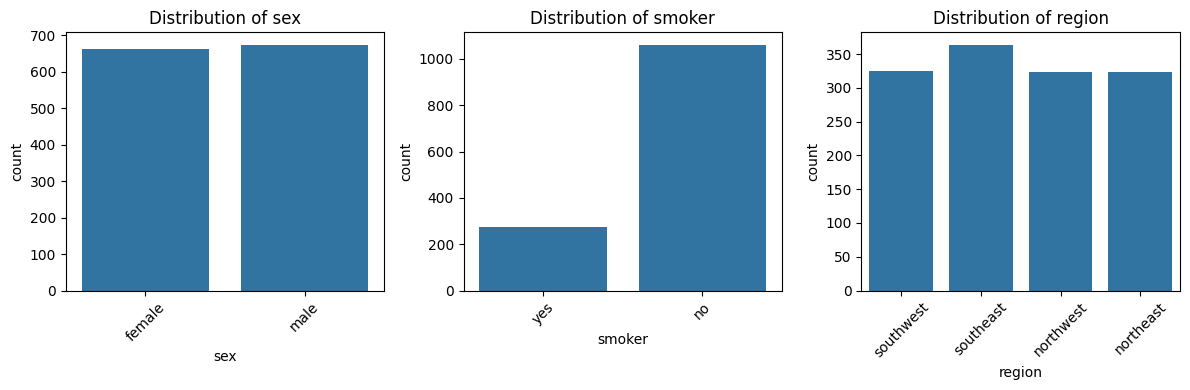

In [17]:
# STEP 7) Data Understanding:

# 7.B) Univariate Categorical Analysis:

!pip install seaborn matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


categorical_variables = df.select_dtypes(include=['object']).columns.tolist()


# Calculate the number of rows needed for subplots
 # 3 columns, calculate rows needed
num_rows = int(np.ceil(len(categorical_variables) / 3))

# Adjust figsize as needed
fig, axes = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))
# Flatten to 1D for easier indexing
axes = axes.flatten()

for i, col in enumerate(categorical_variables):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    # Rotate x-axis labels for better readability
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for i in range(len(categorical_variables), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


/tmp/ipykernel_2105/2736090385.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y)


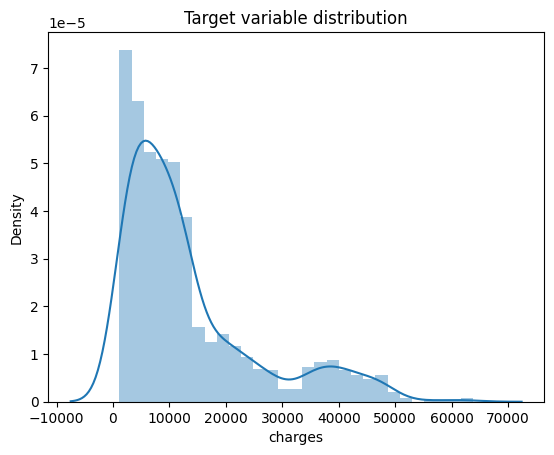


 We can observe here the target variable 'charges' shows a right-skewed distribution.
This leds to the convenience of applying a standard scaler method further in the process.


In [18]:
# STEP 7) Data Understanding:

# 7.C) Target variable distribution:

y = df['charges']

sns.distplot(y)
plt.title("Target variable distribution")
plt.show()

print("\n We can observe here the target variable 'charges' shows a right-skewed distribution.\n"
"This leds to the convenience of applying a standard scaler method further in the process.")

In [23]:
# STEP 7) Data Understanding:

# 7.E) Factorizing categorical predictors to asses its correlation with the target variable

import pandas as pd

def factorize_categorical_features(df):
    """
    Identifies categorical features in a DataFrame and creates new columns with factorized values.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The DataFrame with added columns containing factorized values.
    """
    categorical_predictors = df.select_dtypes(include=['object']).columns.tolist()

    for column_name in categorical_predictors:
        # Create a new column name with "_n" suffix
        new_column_name = column_name + "_n"
        # Factorize the values in the specified column and store in the new column
        df[new_column_name] = pd.factorize(df[column_name])[0]

    return df

# Apply the function to your DataFrame
total_data = factorize_categorical_features(df.copy())  # Create a copy to avoid modifying the original df
#total_data ejecuta la función factorize_categorical_features() pero sobre una copia de df no sobre df mismo!!!

# Display the modified DataFrame
total_data.head()

,age,sex,bmi,children,smoker,region,charges,sex_n,smoker_n,region_n
0,19,female,27.900,0,yes,southwest,16884.92400,0,0,0
1,18,male,33.770,1,no,southeast,1725.55230,1,1,1
2,28,male,33.000,3,no,southeast,4449.46200,1,1,1
3,33,male,22.705,0,no,northwest,21984.47061,1,1,2
4,32,male,28.880,0,no,northwest,3866.85520,1,1,2


In a first overal correlations overiview, we see some direct correlation between 'charges' and 3 ranges of age,
an inverse correlation between 'charges' and 'children'.


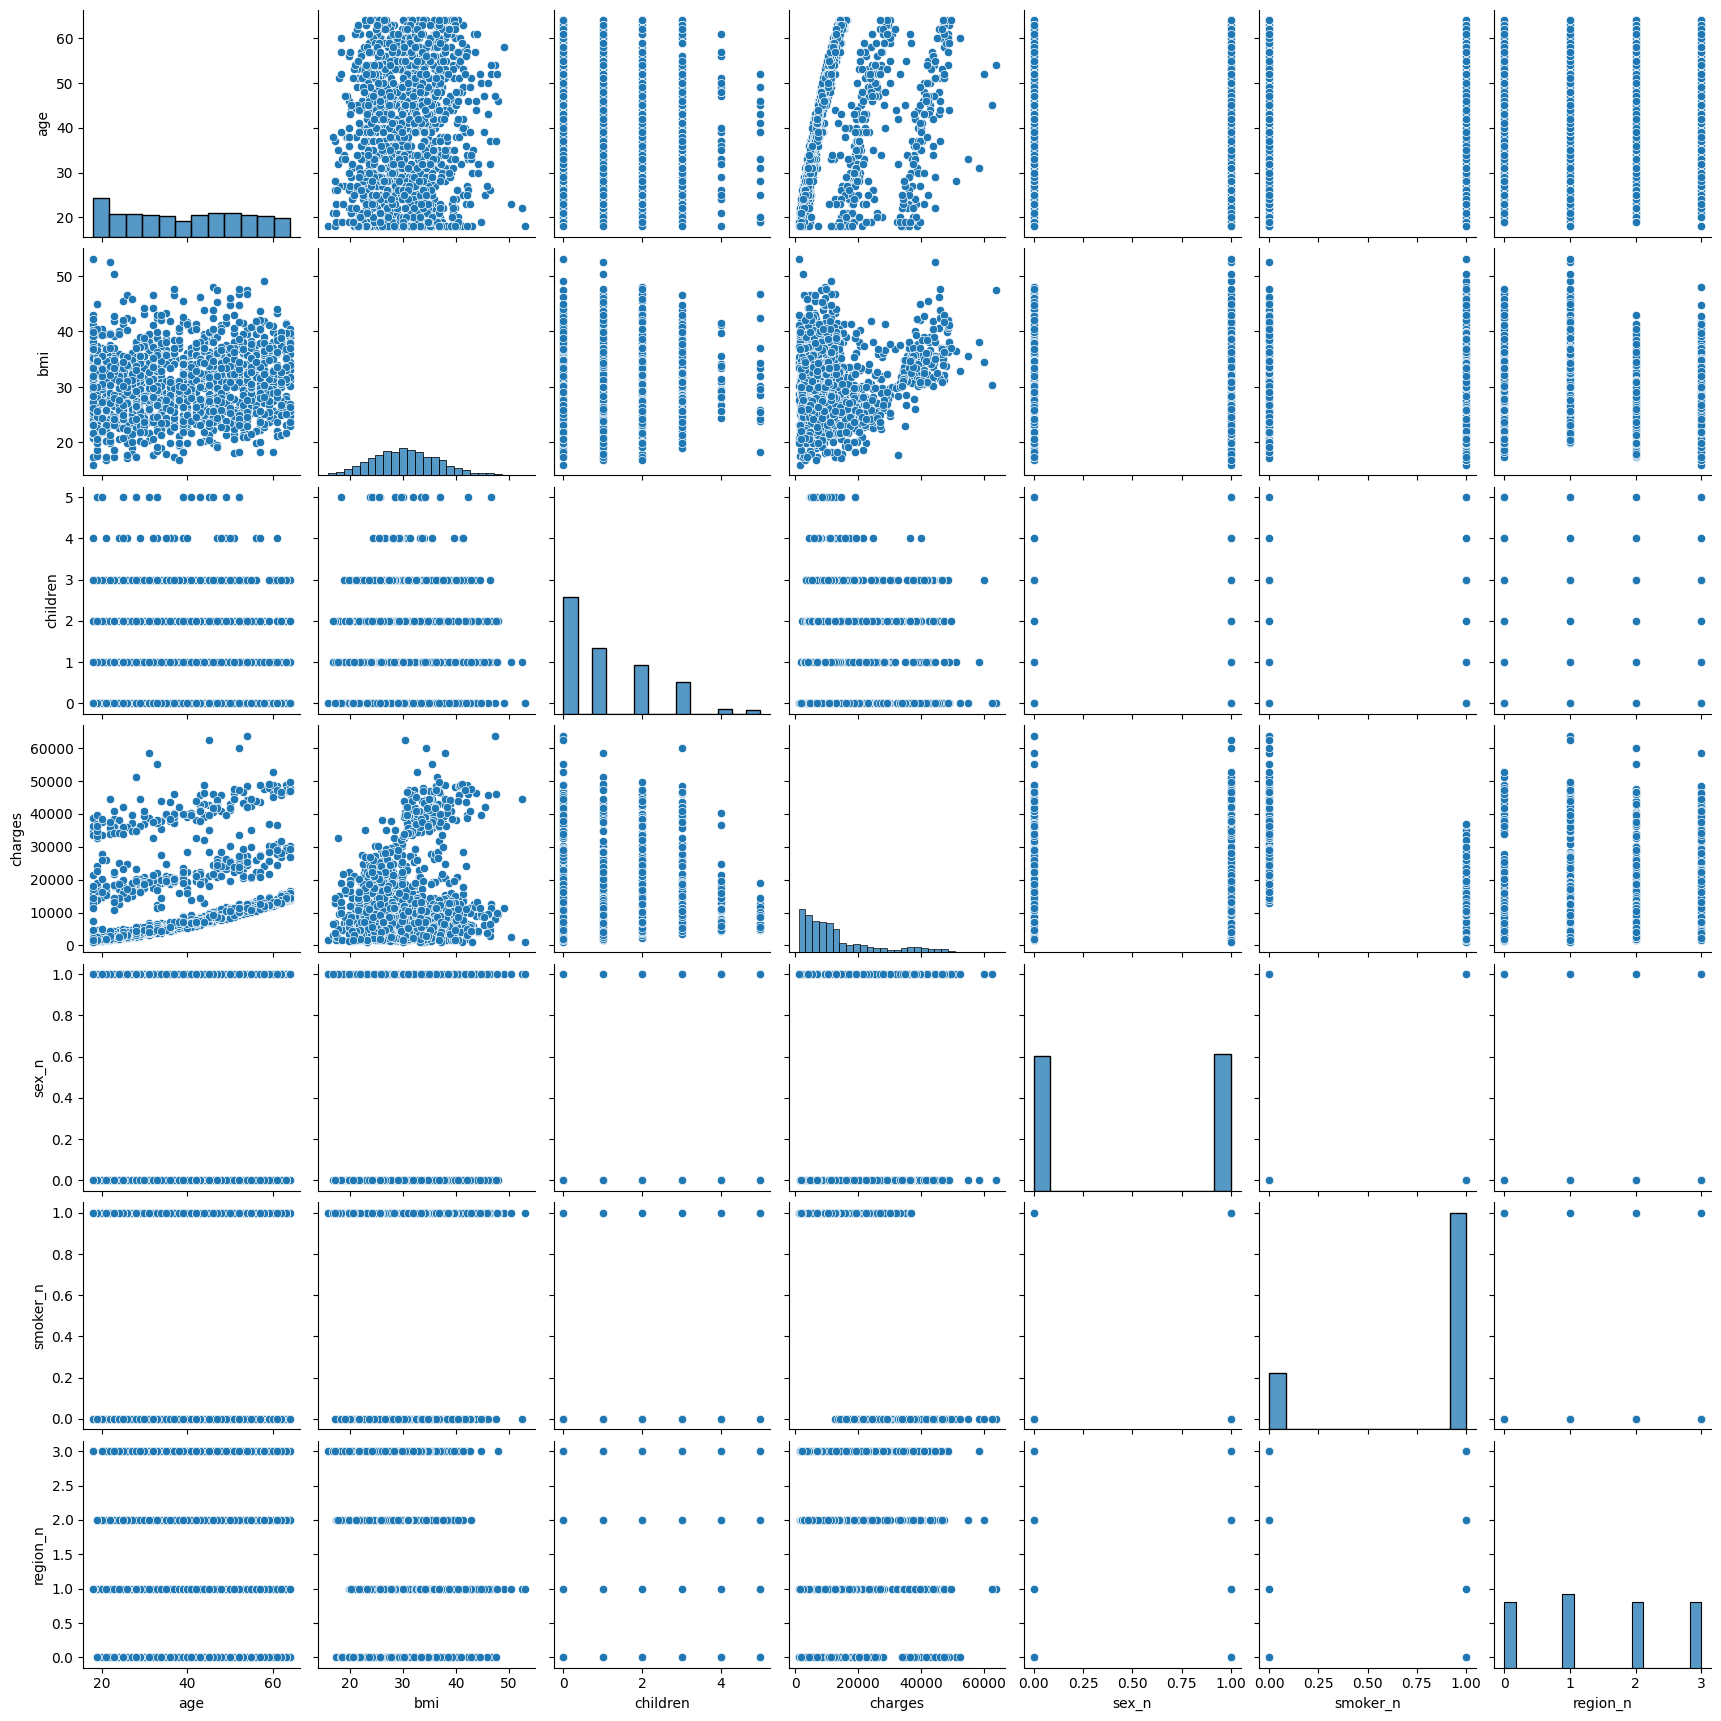

In [27]:
# STEP 7) Data Understanding:

# 7.D) Scatterplot Correlations Overview

df_correlations_no_target = total_data.select_dtypes(include=['int64','float64']).drop(columns = 'charges')

df_correlations_with_target = total_data.select_dtypes(include=['int64', 'float64'])


correlations = total_data.select_dtypes(include=['int64', 'float64'])
df_correlations = pd.DataFrame(correlations)
sns.pairplot(data = df_correlations)


print("In a first overal correlations overiview, we see some direct correlation between 'charges' and 3 ranges of age,\n"
"an inverse correlation between 'charges' and 'children'.")


In these plots we can start seeing the main correlations of the predictors above/below ±0.1 with the target variable charges.
Specifically in this case:

          Correlation with Target charges
age                              0.297606
bmi                              0.198461
smoker_n                        -0.787217 



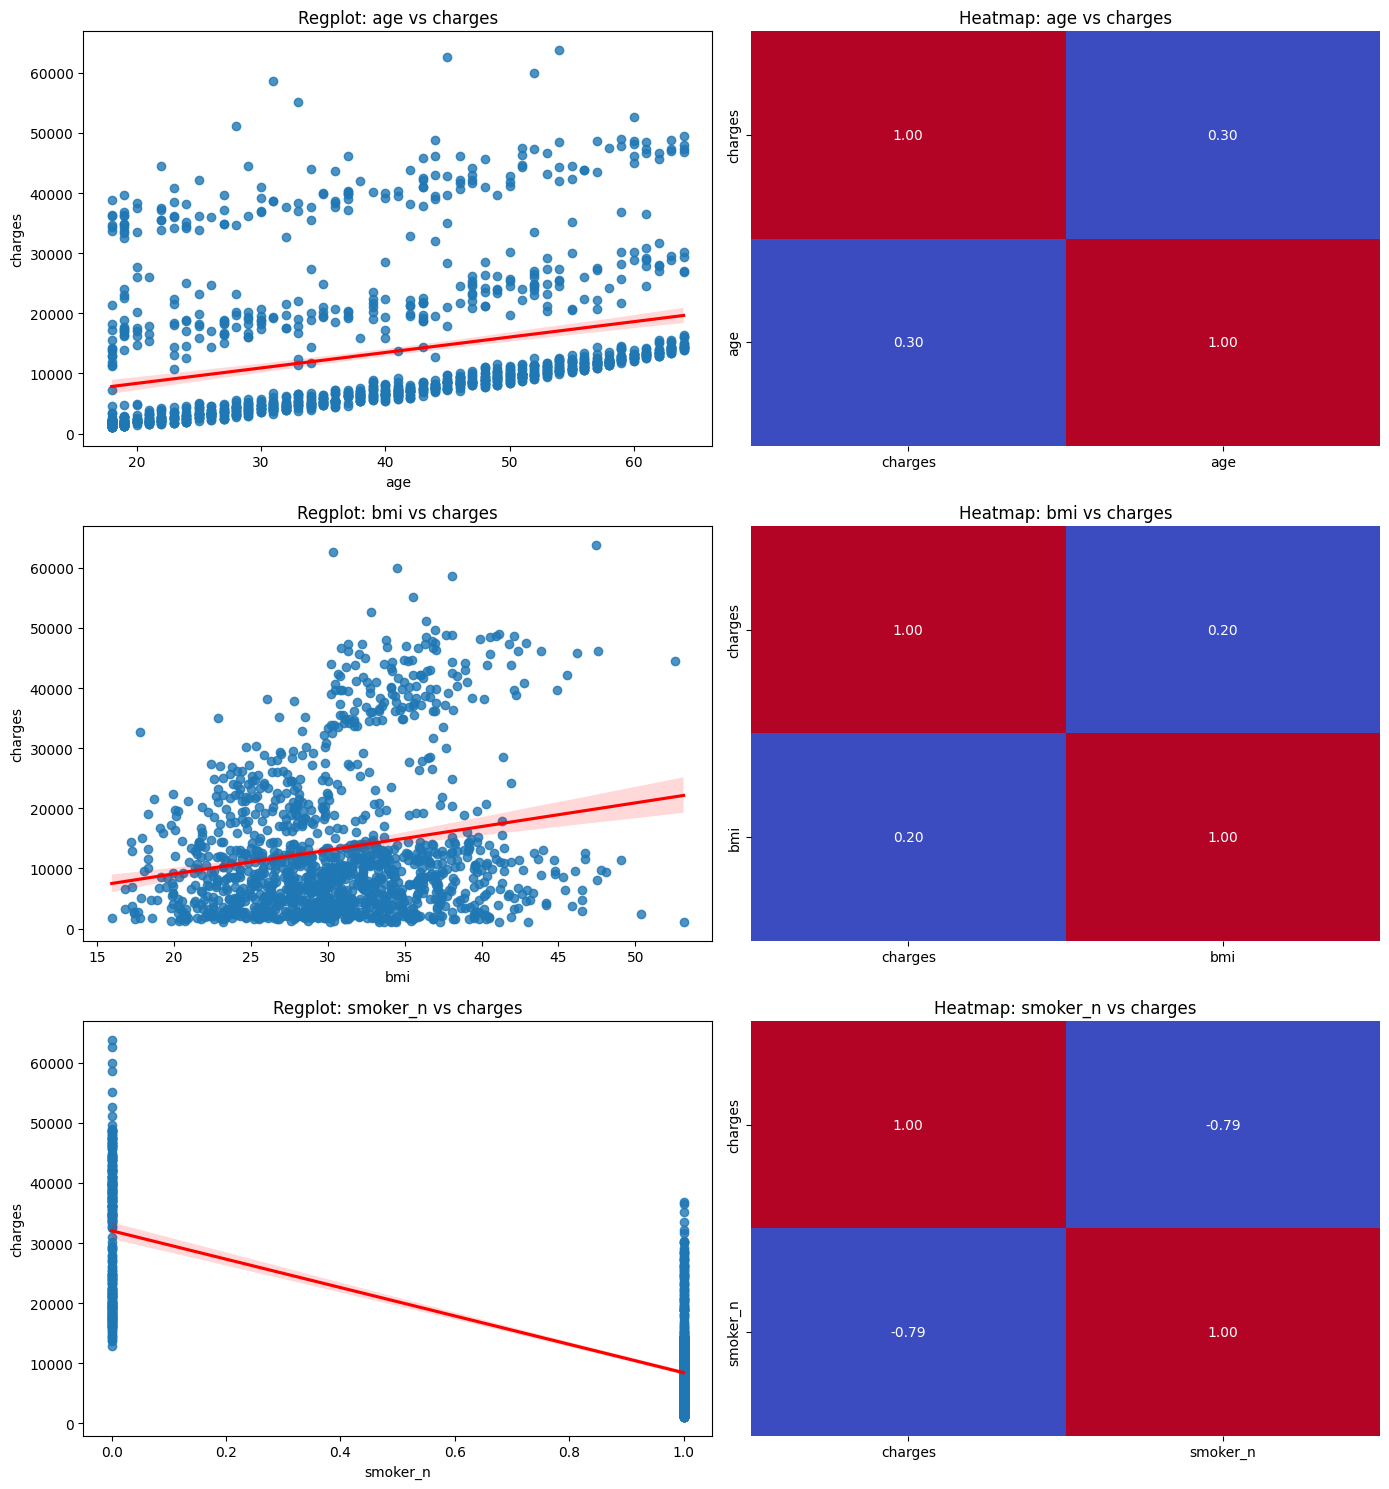

In [28]:
# STEP 7) Data Understanding:

# 7.E) Viusalizing correlations between the most correlated predictors with the target:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_correlations_with_target(df_correlations_with_target, target_variable, correlation_threshold=0.1):
    """
    Plots scatter plots with regression lines (regplots) and heatmaps for predictors with a correlation
    above a threshold with the target variable. Also prints a table with the selected correlations.

    Args:
        df_correlations_with_target (pd.DataFrame): The DataFrame containing numerical features.
        target_variable (str): The name of the target variable column.
        correlation_threshold (float, optional): The minimum absolute correlation value to be considered. Defaults to 0.1.
    """
    # Calculate correlations with the target variable
    correlations = df_correlations_with_target.corr()[target_variable]

    # Select predictors with correlation above or below the threshold
    selected_predictors = correlations[abs(correlations) > correlation_threshold].drop(target_variable)

    # Print a table of selected correlations
    print(f"\nIn these plots we can start seeing the main correlations of the predictors above/below ±{correlation_threshold} with the target variable {target_variable}.\n"
    "Specifically in this case:\n")
    correlation_table = selected_predictors.sort_values(ascending=False).to_frame()
    correlation_table.columns = [f'Correlation with Target {target_variable}']
    print(correlation_table, "\n")

    # Create subplots grid for regplots and heatmaps
    num_plots = len(selected_predictors)
    num_rows = num_plots  # Each predictor gets one row (regplot + heatmap side by side)
    fig, axes = plt.subplots(num_rows, 2, figsize=(14, 5 * num_rows))

    # Handle case where there's only one predictor (axes won't be a 2D array)
    if num_plots == 1:
        axes = [axes]

    # Plot for each selected predictor
    for i, predictor in enumerate(selected_predictors.index):
        # Scatter plot with regression line (regplot)
        sns.regplot(
            ax=axes[i][0],
            data=df_correlations_with_target,
            x=predictor,
            y=target_variable,
            line_kws={"color": "red"}
        )
        axes[i][0].set_title(f"Regplot: {predictor} vs {target_variable}")

        # Heatmap for correlation between the predictor and the target variable
        sns.heatmap(
            df_correlations_with_target[[target_variable, predictor]].corr(),
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            cbar=False,
            ax=axes[i][1]
        )
        axes[i][1].set_title(f"Heatmap: {predictor} vs {target_variable}")

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


# Example usage
target_variable = 'charges'
correlation_threshold = 0.1
correlations = df_correlations_with_target.corr()[target_variable].drop(target_variable)

plot_correlations_with_target(df_correlations_with_target, target_variable, correlation_threshold)



In [29]:
# STEP 8) Scaling the data using Standard Scaler method


# Applying the scaler:
scaler = StandardScaler()

# DATAFRAME READY TO BE SCALED (Includes all the features as numerical and excludes the target)
# df_correlations_no_target  # This was the problematic variable
df_correlations_with_target = total_data.select_dtypes(include=['int64', 'float64'])


# Instead of using df_correlations_no_target directly,
# access its columns using .columns to get a list of column names
scal_features = scaler.fit_transform(total_data[df_correlations_with_target.columns])

total_data_scal = pd.DataFrame(scal_features, index = total_data.index, columns = df_correlations_with_target.columns)
total_data_scal.head()

,age,bmi,children,charges,sex_n,smoker_n,region_n
0,-1.442077,-0.452999,-0.909856,0.297129,-1.009023,-1.968734,-1.342420
1,-1.513335,0.509222,-0.080117,-0.955074,0.991058,0.507941,-0.437540
2,-0.800751,0.383002,1.579361,-0.730072,0.991058,0.507941,-0.437540
3,-0.444459,-1.304573,-0.909856,0.718364,0.991058,0.507941,0.467341
4,-0.515717,-0.292356,-0.909856,-0.778197,0.991058,0.507941,0.467341


In [33]:
# STEP 9: Data Split

import pandas as pd
from sklearn.model_selection import train_test_split


X = total_data_scal.drop("charges", axis = 1)
y = total_data_scal["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


X_train.head()

,age,bmi,children,sex_n,smoker_n,region_n
1114,-1.157043,-1.008694,-0.909856,0.991058,0.507941,1.372222
968,-1.299560,-0.806251,0.749622,0.991058,0.507941,1.372222
600,-1.513335,1.392761,-0.909856,-1.009023,0.507941,-0.437540
170,1.693295,1.771420,-0.909856,0.991058,0.507941,-0.437540
276,-1.442077,-1.647170,0.749622,0.991058,0.507941,0.467341


In [42]:
# STEP 10) Features Selecttion using f_regression

from sklearn.feature_selection import SelectKBest, f_regression

k = 4
selection_model = SelectKBest(f_regression, k = k)
selection_model.fit(X_train, y_train)

selected_columns = X_train.columns[selection_model.get_support()]
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = selected_columns)
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = selected_columns)

X_train_sel.head()


,age,bmi,children,smoker_n
0,-1.157043,-1.008694,-0.909856,0.507941
1,-1.299560,-0.806251,0.749622,0.507941
2,-1.513335,1.392761,-0.909856,0.507941
3,1.693295,1.771420,-0.909856,0.507941
4,-1.442077,-1.647170,0.749622,0.507941


In [44]:
# STEP 11) Linear Regression Model

k = k

# Setting up the model
linear_pred_model = LinearRegression()

# Training
linear_pred_model.fit(X_train, y_train)


print(f"Intercept (b0): {linear_pred_model.intercept_}")
print(f"Coeficients for all {k} the predictors : {linear_pred_model.coef_}")

# Model prediction
X_test
y_pred = linear_pred_model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

print(f"Mean square error: {mean_squared_error(y_test, y_pred)}")
print(f"Root Mean square error: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")





Intercept (b0): -0.00021932773887733178
Coeficients for all 4 the predictors : [ 0.28891266  0.15990276  0.05735748 -0.00293278 -0.79068622  0.03240669]
Mean square error: 0.2722329597345128
Root Mean square error: 0.5217594845659375
Coefficient of determination: 0.7503906756076318
